## Plan
- create model
    - male or female
    - CH, AD, EL
- extract additive infomation
    - length
    - sceptrum infomation

In [1]:
import os 
import numpy as np
import pandas as pd
import librosa
import pyworld
import time
import shutil
import matplotlib.pyplot as plt

from tools import *
from model import *

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
seed_value = 0
np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [3]:
data_dir = "../data/NTT_corevo"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [4]:
class_train = pd.read_csv(os.path.join(data_dir, "class_train.tsv"), delimiter='\t', header=None)
sample_submit = pd.read_csv(os.path.join(data_dir, "class_train.tsv"), delimiter='\t', header=None)

In [5]:
class_train.tail()

,0,1
37801,fff371f8fd363481780cf71abadd3912,FE_EL
37802,fffad7d70023ac8019976bfc7d9ba36d,MA_EL
37803,fffb68964f56e10022d62feba2e538d3,FE_AD
37804,fffdd34e46338d68f3eb7081b2c7f069,FE_AD
37805,ffff83dd1058ef7fd97151be4d61651f,MA_AD


In [6]:
sample_submit.head()

,0,1
0,0002f1cd968ca78ada9e1c7037224773,MA_CH
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD
2,0003b32f378b001f0f73bf0981da8773,MA_CH
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH
4,0005678b57ca265a65f8ef0cc7481277,MA_AD


In [7]:
class_train[class_train[0] == "fff371f8fd363481780cf71abadd3912"]

,0,1
37801,fff371f8fd363481780cf71abadd3912,FE_EL


In [8]:
train_data_dir = os.path.join(data_dir, "train")
files = os.listdir(train_data_dir)
list_label = []

if (False):
    if not os.path.exists(os.path.join(data_dir, "labeled/00/")):
        os.makedirs(os.path.join(data_dir, "labeled/00/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/01/")):
        os.makedirs(os.path.join(data_dir, "labeled/01/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/02/")):
        os.makedirs(os.path.join(data_dir, "labeled/02/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/03/")):
        os.makedirs(os.path.join(data_dir, "labeled/03/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/04/")):
        os.makedirs(os.path.join(data_dir, "labeled/04/"))
    if not os.path.exists(os.path.join(data_dir, "labeled/05/")):
        os.makedirs(os.path.join(data_dir, "labeled/05/"))
    for file in files:
        file_id = file[:-4]
        label = class_train[class_train[0] == file_id].values[0,1]
        if (label == "FE_CH"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/00/" + file))
        elif (label == "FE_AD"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/01/" + file))
        elif (label == "FE_EL"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/02/" + file))
        elif (label == "MA_CH"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/03/" + file))
        elif (label == "MA_AD"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/04/" + file))
        elif (label == "MA_EL"):
            shutil.copy(os.path.join(train_data_dir, file), os.path.join(data_dir, "labeled/05/" + file))

num_labels = np.zeros((6,))
for i in range(6):
    num_labels[i] = len(os.listdir(os.path.join(data_dir, "labeled/0" + str(i))))

## Labels
- 0: female child
- 1: female adult
- 2: female elder
- 3: male child
- 4: male adult
- 5: male elder

/home/takiguchi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


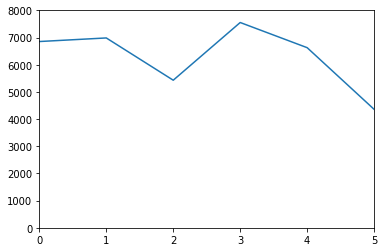

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(num_labels)
ax.set_xlim(0,5)
ax.set_ylim(0, 8000)
fig.show()

In [10]:
sampling_rate = 16000
num_mcep = 36
frame_period = 5.0
n_frames = 512
num_label = 6

In [11]:
def data_load(batch_size = 1, label = -1, path=""):
    data_list = []
    label_list = []
    
    if (label == -1):
        random_label = True 
    else:
        random_label =  False
        
    for i in range(batch_size):
        
        if random_label :
            label = np.random.randint(0, num_label)
        
        if path == "":
            sample_data_dir = os.path.join(data_dir, "labeled/{:02}".format(label))
            file = np.random.choice(os.listdir(sample_data_dir))
        else:
            sample_data_dir = "./"
            file = path
        
        frames = 0
        count = 0
        while frames < n_frames:

            wav, _ = librosa.load(os.path.join(sample_data_dir, file), sr = sampling_rate, mono = True)
            wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)

            if (count == 0):
                mc_transposed = np.array(mc).T
            else:
                mc_transposed = np.concatenate([mc_transposed, np.array(mc).T], axis =1)
            frames = np.shape(mc_transposed)[1]

            mean = np.mean(mc_transposed)
            std = np.std(mc_transposed)
            mc_norm = (mc_transposed - mean)/std

            count += 1

        start_ = np.random.randint(frames - n_frames + 1)
        end_ = start_ + n_frames

        data_list.append(mc_norm[:,start_:end_])
        label_list.append(label)

    return torch.Tensor(data_list).view(batch_size, 1, num_mcep, n_frames), torch.Tensor(label_list).view(batch_size, 1)


In [12]:
a, b = data_load(batch_size=4, label=-1)

In [13]:
print(a.shape)
print(b.shape)
print(b)

torch.Size([4, 1, 36, 512])
torch.Size([4, 1])
tensor([[4.],
        [3.],
        [1.],
        [2.]])


In [14]:
model_dir_vae = "../model/NTT_corevo/VAE"
model_name_vae = "VAE_lr3-4_e10000_b4"

def model_load_VAE():
    model = VAE()
    model.load_state_dict(torch.load(os.path.join(model_dir_vae, model_name_vae)))
    return model
    
model_dir_classifier = "../model/NTT_corevo/Classifier"
model_name_classifier = [
    "Classifier_lr3-4_e2000_b4_label0",
    "Classifier_lr3-4_e2000_b4_label1",
    "Classifier_lr3-4_e2000_b4_label2",
    "Classifier_lr3-4_e2000_b4_label3",
    "Classifier_lr3-4_e2000_b4_label4",
    "Classifier_lr3-4_e2000_b4_label5",
    "Classifier_lr3-4_e2000_b4_child",
    "Classifier_lr3-4_e2000_b4_adult",
    "Classifier_lr3-4_e2000_b4_elder",
    "Classifier_lr3-4_e2000_b4_male",
    "Classifier_lr3-4_e2000_b4_female",
    
]

def model_load_classifier(label):
    model = Classifier()
    model.load_state_dict(torch.load(os.path.join(model_dir_classifier, model_name_classifier[label])))
    return model

In [15]:
train_df = pd.DataFrame()
answer_df = pd.DataFrame()
test_df = pd.DataFrame()

In [16]:
a = class_train.values[0]

In [17]:
a

array(['0002f1cd968ca78ada9e1c7037224773', 'MA_CH'], dtype=object)

In [18]:
feature_data_dir = "../feature_data/NTT_corevo"
train_data_dir = os.path.join(data_dir, "train")
test_data_dir = os.path.join(data_dir, "test")

In [19]:
num_train_data = len(os.listdir(train_data_dir))
num_test_data =len(os.listdir(test_data_dir))

In [ ]:
list_answer = np.zeros((num_train_data))
for i in range(num_train_data):
    _, label = class_train.values[i]
    if (label == "FE_CH"):
        list_answer[i] = 0
    elif (label == "FE_AD"):
        list_answer[i] = 1
    elif (label == "FE_EL"):
        list_answer[i] = 2
    elif (label == "MA_CH"):
        list_answer[i] = 3
    elif (label == "MA_AD"):
        list_answer[i] = 4
    elif (label == "MA_EL"):
        list_answer[i] = 5
np.save(os.path.join(feature_data_dir, "answer.npy"), list_answer)

In [ ]:
list_label = np.zeros((num_train_data, num_label))
list_appendix = np.zeros((num_train_data, 5))  # child, adult, elder, male, female

list_test_label = np.zeros((num_test_data, num_label))
list_test_appendix = np.zeros((num_test_data, 5))

model_vae = model_load_VAE()
model_vae.eval()
                      
model_classifiers = []
model_classifiers_appendix = []
for label in range(num_label):
    model_classifier = model_load_classifier(label)
    model_classifier.eval()
    model_classifiers.append(model_classifier)
for label in range(5):
    model_classifier = model_load_classifier(label+5)
    model_classifier.eval()
    model_classifiers_appendix.append(model_classifier)
    
for i in range(num_train_data):
    if (i%100==0):
        print("{}%".format(i*100//num_train_data))
    file, _ = class_train.values[i]
    x_, _ = data_load(path=os.path.join(train_data_dir, file+".wav"))
    z_ = model_vae.predict(x_)
    pred = []
    for label, classifier in enumerate(model_classifiers):
        p = classifier.predict(z_).data.cpu().numpy().reshape(1,)[0]
        list_label[0, label] = p
        pred.append(p)
    for label, classifier in enumerate(model_classifiers_appendix):
        p = classifier.predict(z_).data.cpu().numpy().reshape(1,)[0]
        list_appendix[0, label] = p
        pred.append(p)
    if (i <100):
        print("True Label {}".format(int(list_answer[i])))
        for j in range(num_label):
            print("Classifier {}  :  Value  {:.03}".format(j, pred[j]))
        print("Classifier 0,3  :  Value  {:.03}".format(pred[6]))
        print("Classifier 1,4 :  Value  {:.03}".format(pred[7]))
        print("Classifier 2,5  :  Value  {:.03}".format(pred[8]))
        print("Classifier 0,1,2  :  Value  {:.03}".format(pred[9]))
        print("Classifier 3,4,5  :  Value  {:.03}".format(pred[10]))
            
np.save(os.path.join(feature_data_dir, "predicted_label.npy"), list_label)
np.save(os.path.join(feature_data_dir, "predicted_appendix.npy"), list_appendix)

for label in range(num_label):
    model_classifier = model_load_classifier(label)
    model_classifier.eval()
    for file in os.listdir(test_data_dir):
        if (i%100==0):
            print("Label  {} : {}%".format(label, i*100//num_test_data))
        x_, _ = data_load(path=os.path.join(test_data_dir, file))
        z_ = model_vae.predict(x_)
        for label, classifier in enumerate(model_classifiers):
            p = classifier.predict(z_).data.cpu().numpy().reshape(1,)[0]
            list_test_label[0, label] = p
        for label, classifier in enumerate(model_classifiers_appendix):
            p = classifier.predict(z_).data.cpu().numpy().reshape(1,)[0]
            list_label[0, label] = p
            list_test_appendix[0, label] = model_classifier.predict(z_).data.cpu().numpy().reshape(1,)[0]
            
np.save(os.path.join(feature_data_dir, "test_predicted_label.npy"), list_test_label)
np.save(os.path.join(feature_data_dir, "test_predicted_appendix.npy"), list_test_appendix)

True Label 3
Classifier 0  :  Value  0.171
Classifier 1  :  Value  0.213
Classifier 2  :  Value  0.249
Classifier 3  :  Value  0.194
Classifier 4  :  Value  0.19
Classifier 5  :  Value  0.162
Classifier 0,3  :  Value  0.162
Classifier 1,4 :  Value  0.316
Classifier 2,5  :  Value  0.393
Classifier 0,1,2  :  Value  0.359
Classifier 3,4,5  :  Value  0.493
True Label 1
Classifier 0  :  Value  0.117
Classifier 1  :  Value  0.285
Classifier 2  :  Value  0.255
Classifier 3  :  Value  0.106
Classifier 4  :  Value  0.298
Classifier 5  :  Value  0.101
Classifier 0,3  :  Value  0.101
Classifier 1,4 :  Value  0.277
Classifier 2,5  :  Value  0.427
Classifier 0,1,2  :  Value  0.366
Classifier 3,4,5  :  Value  0.497
True Label 3
Classifier 0  :  Value  0.218
Classifier 1  :  Value  0.195
Classifier 2  :  Value  0.197
Classifier 3  :  Value  0.218
Classifier 4  :  Value  0.152
Classifier 5  :  Value  0.166
Classifier 0,3  :  Value  0.166
Classifier 1,4 :  Value  0.501
Classifier 2,5  :  Value  0.311
C

True Label 4
Classifier 0  :  Value  0.28
Classifier 1  :  Value  0.106
Classifier 2  :  Value  0.132
Classifier 3  :  Value  0.303
Classifier 4  :  Value  0.173
Classifier 5  :  Value  0.232
Classifier 0,3  :  Value  0.232
Classifier 1,4 :  Value  0.564
Classifier 2,5  :  Value  0.271
Classifier 0,1,2  :  Value  0.313
Classifier 3,4,5  :  Value  0.54
True Label 2
Classifier 0  :  Value  0.0604
Classifier 1  :  Value  0.225
Classifier 2  :  Value  0.159
Classifier 3  :  Value  0.108
Classifier 4  :  Value  0.134
Classifier 5  :  Value  0.174
Classifier 0,3  :  Value  0.174
Classifier 1,4 :  Value  0.287
Classifier 2,5  :  Value  0.472
Classifier 0,1,2  :  Value  0.376
Classifier 3,4,5  :  Value  0.446
True Label 1
Classifier 0  :  Value  0.124
Classifier 1  :  Value  0.177
Classifier 2  :  Value  0.141
Classifier 3  :  Value  0.0788
Classifier 4  :  Value  0.191
Classifier 5  :  Value  0.226
Classifier 0,3  :  Value  0.226
Classifier 1,4 :  Value  0.25
Classifier 2,5  :  Value  0.422
C

True Label 0
Classifier 0  :  Value  0.309
Classifier 1  :  Value  0.0922
Classifier 2  :  Value  0.139
Classifier 3  :  Value  0.205
Classifier 4  :  Value  0.0553
Classifier 5  :  Value  0.176
Classifier 0,3  :  Value  0.176
Classifier 1,4 :  Value  0.554
Classifier 2,5  :  Value  0.222
Classifier 0,1,2  :  Value  0.345
Classifier 3,4,5  :  Value  0.481
True Label 4
Classifier 0  :  Value  0.171
Classifier 1  :  Value  0.179
Classifier 2  :  Value  0.211
Classifier 3  :  Value  0.19
Classifier 4  :  Value  0.234
Classifier 5  :  Value  0.126
Classifier 0,3  :  Value  0.126
Classifier 1,4 :  Value  0.302
Classifier 2,5  :  Value  0.414
Classifier 0,1,2  :  Value  0.346
Classifier 3,4,5  :  Value  0.525
True Label 3
Classifier 0  :  Value  0.227
Classifier 1  :  Value  0.177
Classifier 2  :  Value  0.166
Classifier 3  :  Value  0.26
Classifier 4  :  Value  0.106
Classifier 5  :  Value  0.18
Classifier 0,3  :  Value  0.18
Classifier 1,4 :  Value  0.488
Classifier 2,5  :  Value  0.246
Cl

True Label 1
Classifier 0  :  Value  0.176
Classifier 1  :  Value  0.241
Classifier 2  :  Value  0.198
Classifier 3  :  Value  0.167
Classifier 4  :  Value  0.171
Classifier 5  :  Value  0.177
Classifier 0,3  :  Value  0.177
Classifier 1,4 :  Value  0.247
Classifier 2,5  :  Value  0.42
Classifier 0,1,2  :  Value  0.388
Classifier 3,4,5  :  Value  0.48
True Label 4
Classifier 0  :  Value  0.182
Classifier 1  :  Value  0.1
Classifier 2  :  Value  0.186
Classifier 3  :  Value  0.203
Classifier 4  :  Value  0.198
Classifier 5  :  Value  0.185
Classifier 0,3  :  Value  0.185
Classifier 1,4 :  Value  0.458
Classifier 2,5  :  Value  0.283
Classifier 0,1,2  :  Value  0.341
Classifier 3,4,5  :  Value  0.523
True Label 0
Classifier 0  :  Value  0.0418
Classifier 1  :  Value  0.268
Classifier 2  :  Value  0.258
Classifier 3  :  Value  0.162
Classifier 4  :  Value  0.238
Classifier 5  :  Value  0.108
Classifier 0,3  :  Value  0.108
Classifier 1,4 :  Value  0.309
Classifier 2,5  :  Value  0.423
Cla

True Label 0
Classifier 0  :  Value  0.174
Classifier 1  :  Value  0.177
Classifier 2  :  Value  0.19
Classifier 3  :  Value  0.121
Classifier 4  :  Value  0.188
Classifier 5  :  Value  0.214
Classifier 0,3  :  Value  0.214
Classifier 1,4 :  Value  0.257
Classifier 2,5  :  Value  0.389
Classifier 0,1,2  :  Value  0.381
Classifier 3,4,5  :  Value  0.491
True Label 5
Classifier 0  :  Value  0.27
Classifier 1  :  Value  0.128
Classifier 2  :  Value  0.139
Classifier 3  :  Value  0.262
Classifier 4  :  Value  0.151
Classifier 5  :  Value  0.211
Classifier 0,3  :  Value  0.211
Classifier 1,4 :  Value  0.512
Classifier 2,5  :  Value  0.234
Classifier 0,1,2  :  Value  0.31
Classifier 3,4,5  :  Value  0.533
True Label 1
Classifier 0  :  Value  0.179
Classifier 1  :  Value  0.277
Classifier 2  :  Value  0.136
Classifier 3  :  Value  0.129
Classifier 4  :  Value  0.134
Classifier 5  :  Value  0.235
Classifier 0,3  :  Value  0.235
Classifier 1,4 :  Value  0.352
Classifier 2,5  :  Value  0.329
Cla

In [ ]:
list_f0 = np.zeros((num_train_data, 3)) # mean, std, len
for i in range(num_train_data):
    file, _ = class_train.values[i]
    wav, _ = librosa.load(os.path.join(train_data_dir, file+".wav"), sr = sampling_rate, mono = True)
    wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
    wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
    f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)
    f0_mean = np.mean(np.nonzero(f0))/300.
    f0_std = np.std(np.nonzero(f0))/300.    
    list_f0[i, 0] = f0_mean
    list_f0[i, 1] = f0_std
    list_f0[i, 2] = len(f0)
    if i%100 == 0:
        print("{:.2}%".format(i*100./num_train_data))
np.save(os.path.join(feature_data_dir, "f0.npy"), list_f0)

list_test_f0 = np.zeros((num_test_data, 3))
for file in os.listdir(test_data_dir):
    wav, _ = librosa.load(os.path.join(test_data_dir, file), sr = sampling_rate, mono = True)
    wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
    wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
    f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)
    f0_mean = np.mean(np.nonzero(f0))/300.
    f0_std = np.std(np.nonzero(f0))/300.
    list_test_f0[i, 0] = f0_mean
    list_test_f0[i, 1] = f0_std
    list_test_f0[i, 2] = len(f0)
    if i%100 == 0:
        print("{:.2}%".format(i*100./num_test_data)
np.save(os.path.join(feature_data_dir, "test_f0.npy"),  list_test_f0)

In [ ]:
answer_df["answer"] = list_answer

for label in range(num_label+5):
    train_df["label{:01}".format(label)] = list_label[:,label]
train_df["f0_mean"] = list_f0[:,0]
train_df["f0_std"] = list_f0[:,1]
train_df["f0_len"] = list_f0[:,2]
for label in range(num_label+5):
    test_df["label{:01}".format(label)] = list_test_label[:,label]
test_df["f0_mean"] = list_test_f0[:,0]
test_df["f0_std"] = list_test_f0[:,1]
train_df["f0_len"] = list_test_f0[:,2]

train_df["value01"] = list_label[:,11] - list_label[:,10]
test_df["value01"] = list_test_label[:,11] - list_test_label[:,10]

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_df, answer_df)

# Y_pred = random_forest.predict(X_test)
print(round(random_forest.score(train_df, answer_df) * 100, 2))

In [ ]:
submit_df = pd.DataFrame()

In [ ]:
list_id = []
list_label = []

pred_df = random_forest.predict(test_df)

files = os.listdir(test_data_dir)
for i, file in enumerate files:
    name = file[:-4]
    list_id.append(name)
    label = pred_df.values[i]
    if (label == 0):
        list_label.append("FE_CH")
    elif (label == 1):
        list_label.append("FE_AD")
    elif (label == 2):
        list_label.append("FE_EL")
    elif (label == 3):
        list_label.append("MA_CH")
    elif (label == 4):
        list_label.append("MA_AD")
    elif (label == 5):
        list_label.append("MA_EL")
        
submit_df["id"] = list_id
submit_df["label"] = list_label

In [ ]:
submit_df.tail()

In [ ]:
submit_df.to_csv(os.path.join(feature_data_dir, "submit.tsv"), sep='\t', header=False, index=False)

- add "not" label